### BUILD A BASIC CHATBOT WITH LANGGRAPH (GRAPH API)

In [43]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
# add_messages is an exmaple of reducers
from langgraph.graph.message import add_messages


In [44]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

In [45]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [46]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.3-70b-versatile")

In [47]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x114648890>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x11472ddd0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [48]:
# Node Functionality
def chatbot(state:State):
    return {'messages':[llm.invoke(state['messages'])]}


In [49]:
graph_builder = StateGraph(State)

## Adding nodes
graph_builder.add_node('llmchatbot',chatbot)
## Adding edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

# Compile the graph
graph = graph_builder.compile()

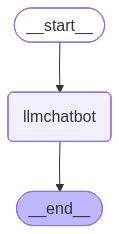

In [50]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [51]:
response = graph.invoke({"messages":"Hi"})

In [52]:
response['messages'][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [53]:
import asyncio
DELAY_SECONDS = 0.01
async for event in graph.astream_events({"messages":"Hi How are you? can you explain me the concept of graph api in langgraph in 50 words only?"}):
    kind = event["event"]
    # We filter specifically for the model's streaming output
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # print with end="" to stream token by token on the same line
            for char in content:
                print(char, end="", flush=True)
                await asyncio.sleep(DELAY_SECONDS)

I'm fine, thanks. LangGraph's Graph API represents language models as graphs, enabling node and edge manipulation for tasks like text generation, summarization, and question-answering, allowing for flexible and customizable language processing workflows.

### Chatbot With Tool

In [54]:
from langchain_community.tools import DuckDuckGoSearchRun

tool = DuckDuckGoSearchRun()
print(tool.invoke("What is LangGraph?"))

12 Dec 2025 · LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. At its core, LangGraph combines ... 22 Aug 2025 · Try LangGraph Hands-On Labs for Free - https://kode.wiki/41WTH62 Learn how LangGraph transforms simple LangChain chatbots into powerful AI agents with ... 3 Nov 2025 · What is LangGraph? LangGraph is an extension of LangChain that introduces a graph-based approach to AI workflows. Instead of chaining steps in one direction, ... 30 Jul 2025 · Key Difference: LangChain is ideal for predictable, step-by-step processes. LangGraph handles complex, iterative, and multi-agent workflows with ease. 6 Jun 2025 · LangGraph emphasizes graph-based workflows and state management, making it ideal for complex applications with sophisticated logic and memory persistence.


In [55]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [56]:
tools=[tool,multiply]

In [57]:
llm_with_tool=llm.bind_tools(tools)

In [58]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x114648890>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x11472ddd0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'duckduckgo_search', 'description': 'A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

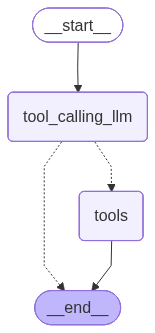

In [59]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [61]:
response['messages'][-1].content

'Read full articles, watch videos, browse thousands of titles and more on the "Artificial intelligence" topic with Google News . 4 days ago · Explore the latest artificial intelligence news with Reuters - from AI breakthroughs and technology trends to regulation, ethics, business and global impact. Jun 25, 2025 · Stay updated with the latest artificial intelligence news , research breakthroughs, product launches, and industry developments. Curated from top sources and updated regularly. 1 day ago · AI News delivers the latest updates in artificial intelligence, machine learning, deep learning, enterprise AI, and emerging tech worldwide. Jan 9, 2026 · Artificial Intelligence News . Everything on AI including futuristic robots with artificial intelligence, computer models of human intelligence and more.'

In [62]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (qmr4713p1)
 Call ID: qmr4713p1
  Args:
    query: recent AI news
================================= Tool Message =================================
Name: duckduckgo_search

Read full articles, watch videos, browse thousands of titles and more on the "Artificial intelligence" topic with Google News . 4 days ago · Explore the latest artificial intelligence news with Reuters - from AI breakthroughs and technology trends to regulation, ethics, business and global impact. Jun 25, 2025 · Stay updated with the latest artificial intelligence news , research breakthroughs, product launches, and industry developments. Curated from top sources and updated regularly. 1 day ago · AI News delivers the latest updates in artificial intelligence, machine learning, deep learning, enterp

In [63]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (pxzzdxxaq)
 Call ID: pxzzdxxaq
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [64]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (p2hwe05ry)
 Call ID: p2hwe05ry
  Args:
    query: recent AI news
  multiply (e6zhzhbvy)
 Call ID: e6zhzhbvy
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: duckduckgo_search

20 hours ago - Artificial Intelligence: Read latest updates on AI like Google AI, ChatGPT, Google Lamda, Bard chatbot and more along with latest news as AI technology advances and makes new progress. All get detailed articles on AI related queries like what is AI, types of artificial intelligence, its applications and future. 9 hours ago - Oracle is considering laying off 20,000 to 30,000 employees to fund an ambitious AI data center expa ... ... Amazon's recent layoffs of 30,000 corporate roles have spar

### React Agent Architecture

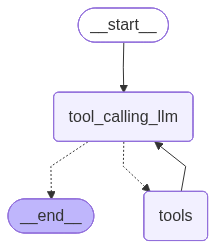

In [65]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (j0rb468db)
 Call ID: j0rb468db
  Args:
    query: recent AI news
  multiply (67etrw5z9)
 Call ID: 67etrw5z9
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: duckduckgo_search

Read full articles, watch videos, browse thousands of titles and more on the "Artificial intelligence" topic with Google News . 4 days ago · Explore the latest artificial intelligence news with Reuters - from AI breakthroughs and technology trends to regulation, ethics, business and global impact. Jun 25, 2025 · Stay updated with the latest artificial intelligence news , research breakthroughs, product launches, and industry developments. Curated from top sources and updated regularly. 1 day ago · AI News

### Adding Memory In Agentic Graph

In [67]:
response=graph.invoke({"messages":"Hello my name is KRish"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is KRish
================================== Ai Message ==================================

Hello KRish, it's nice to meet you. Is there something I can help you with or would you like to chat?


In [68]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I don't have any information about your name. This conversation just started, and I don't have any prior knowledge about you. If you'd like to share your name, I'd be happy to chat with you!


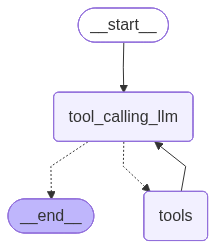

In [69]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [70]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Krish"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='fe6e6c85-4d49-4bf3-9dc7-f912c9da8641'),
  AIMessage(content="Hello Krish, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 334, 'total_tokens': 360, 'completion_time': 0.069158375, 'completion_tokens_details': None, 'prompt_time': 0.017136743, 'prompt_tokens_details': None, 'queue_time': 0.052375127, 'total_time': 0.086295118}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--019c210b-61fc-7b22-8207-b564373bceb3-0', usage_metadata={'input_tokens': 334, 'output_tokens': 26, 'total_tokens': 360})]}

In [71]:
response['messages'][-1].content

"Hello Krish, it's nice to meet you. Is there something I can help you with or would you like to chat?"

In [72]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

print(response['messages'][-1].content)

Yes, I remember your name is Krish.


### Streaming

In [86]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

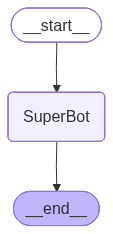

In [87]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [88]:
config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Krish And I like football"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like football', additional_kwargs={}, response_metadata={}, id='55efc403-9510-4956-b9c2-a96be78cdc06'),
  AIMessage(content="Nice to meet you, Krish! Football is an exciting sport, isn't it? Which team or player is your favorite? Do you play football yourself or enjoy watching it?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 45, 'total_tokens': 81, 'completion_time': 0.098490463, 'completion_tokens_details': None, 'prompt_time': 0.003724589, 'prompt_tokens_details': None, 'queue_time': 0.052750321, 'total_time': 0.102215052}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--019c2366-8f1e-7952-87cf-323b8914a20c-0', usage_metadata={'input_tokens': 45, 'output_tokens': 36, 'total_tokens': 81})]}

In [89]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Nice to meet you, Krish! Cricket is an exciting sport, and there are many thrilling matches and tournaments throughout the year. Are you a fan of a particular team or player? Do you have a favorite format of the game, such as Test cricket, ODIs, or T20s?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 45, 'total_tokens': 105, 'completion_time': 0.25488132, 'completion_tokens_details': None, 'prompt_time': 0.011194016, 'prompt_tokens_details': None, 'queue_time': 0.165883183, 'total_time': 0.266075336}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_45180df409', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--019c2366-9949-7873-9ec1-2c295efc2f8b-0', usage_metadata={'input_tokens': 45, 'output_tokens': 60, 'total_tokens': 105})]}}


In [90]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like pickleball"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Krish, it's nice to meet you. Pickleball is a fantastic sport, and it's great that you enjoy playing it. It's a fun and social game that's easy to learn, but challenging to master. What do you like most about pickleball? Is it the speed of the game, the strategy involved, or the social aspect of playing with friends?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 46, 'total_tokens': 123, 'completion_time': 0.176397326, 'completion_tokens_details': None, 'prompt_time': 0.006639113, 'prompt_tokens_details': None, 'queue_time': 0.328571696, 'total_time': 0.183036439}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_43d97c5965', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--019c2366-9f1b-7271-b4ed-a376385a8a8d-0', usage_metadata={'input_tokens': 46, 'output_tokens': 77, 'total_tokens': 123})]}}


In [91]:
for chunk in graph_builder.stream({'messages':"I also like badminton"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like pickleball', additional_kwargs={}, response_metadata={}, id='42827c6b-8ff4-4009-9d5f-908f40b57ca6'), AIMessage(content="Hi Krish, it's nice to meet you. Pickleball is a fantastic sport, and it's great that you enjoy playing it. It's a fun and social game that's easy to learn, but challenging to master. What do you like most about pickleball? Is it the speed of the game, the strategy involved, or the social aspect of playing with friends?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 46, 'total_tokens': 123, 'completion_time': 0.176397326, 'completion_tokens_details': None, 'prompt_time': 0.006639113, 'prompt_tokens_details': None, 'queue_time': 0.328571696, 'total_time': 0.183036439}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_43d97c5965', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--019c2366-9f1b-7271-b4e

In [93]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    kind = event["event"]
    # We filter specifically for the model's streaming output
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # print with end="" to stream token by token on the same line
            for char in content:
                print(char, end="", flush=True)
                await asyncio.sleep(DELAY_SECONDS)

Nice to meet you, Krish! It's great that you enjoy playing cricket. What's your favorite position to play in the team - batsman, bowler, or an all-rounder? Do you have a local team that you play with, or is it more of a casual game with friends?